# Imports

In [1]:
import itertools
import pandas as pd
import numpy as np
from random import gauss, shuffle 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans

import os
import lightgbm as lgb

from  datetime import datetime, timedelta
import gc, copy

from gensim.models import Word2Vec 

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [ ]:
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
  
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})    

In [3]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [ ]:
xdat = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
xdat = xdat.loc[xdat.state_id == 'CA']

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


xdat = reduce_mem_usage(xdat)

Memory usage of dataframe is 178.65 MB
Memory usage after optimization is: 35.74 MB
Decreased by 80.0%


# EDA

In [ ]:
xdat = pd.melt(xdat, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales').dropna()
xcal = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')


In [7]:
xdat = pd.merge(xdat, xcal, on='d', how='left')
del xcal

In [ ]:
xdat.drop(['d', 'wm_yr_wk', 'weekday', 'month', 'year',  'event_name_1', 'event_type_1', 
           'event_name_2', 'event_type_2', 'snap_TX', 'snap_WI', 'state_id'], 
                  axis = 1, inplace = True)
xdat.head(3)

In [ ]:
df = xdat.loc[(xdat.item_id == 'HOBBIES_1_288') & (xdat.store_id == 'CA_1') ][['date', 'sales']].copy()
df = df.loc[(df.date >= '2012-01-01') & (df.date <= '2015-06-30')]
df.set_index('date').sales.plot()

Takeaway:
- time series as regression
- (lagged) rolling statistics
- distribution of target
- careful about ranges $\rightarrow$ extrapolation


In [ ]:
xtrain = pd.read_csv('../input/partial-visuelle/train.csv')

In [ ]:
xtest = pd.read_csv('../input/partial-visuelle/test.csv')

In [ ]:
target_cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
cat_cols = ['category', 'day', 'week', 'month', 'color', 'fabric', 'extra' ]

y0, y1 = xtrain[target_cols].copy(), xtest[target_cols].copy()
x0, x1 = xtrain[cat_cols].copy(), xtest[cat_cols].copy()

In [ ]:
xdat = pd.concat([x0,x1], axis = 0)
xdat = pd.get_dummies(xdat)
x0 = xdat.iloc[:x0.shape[0]]
x1 = xdat.iloc[x0.shape[0]:]
del xdat

In [ ]:
base_model = Ridge()
mo_base = MultiOutputRegressor(base_model, n_jobs=-1)
mo_base.fit(x0, y0)
mo_prediction = mo_base.predict(x1) 

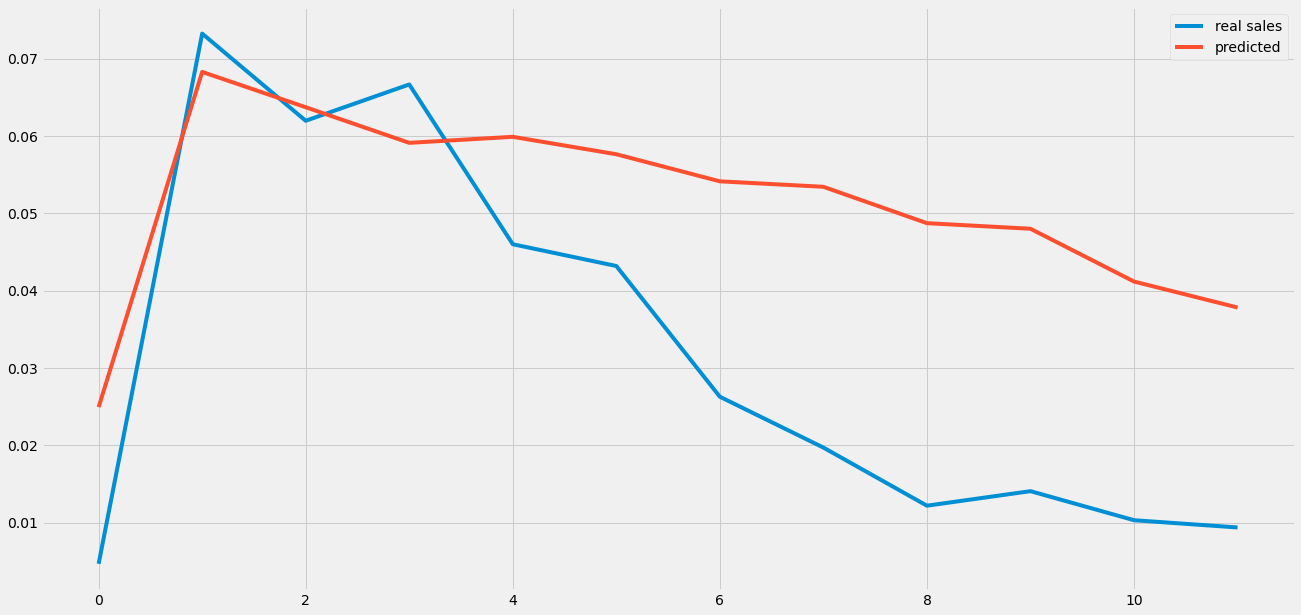

In [39]:
ii = 0 
plt.plot(y0.values[ii,:], label = "real sales")
plt.plot(mo_prediction[ii,:], label = "predicted")
plt.legend()
plt.show()

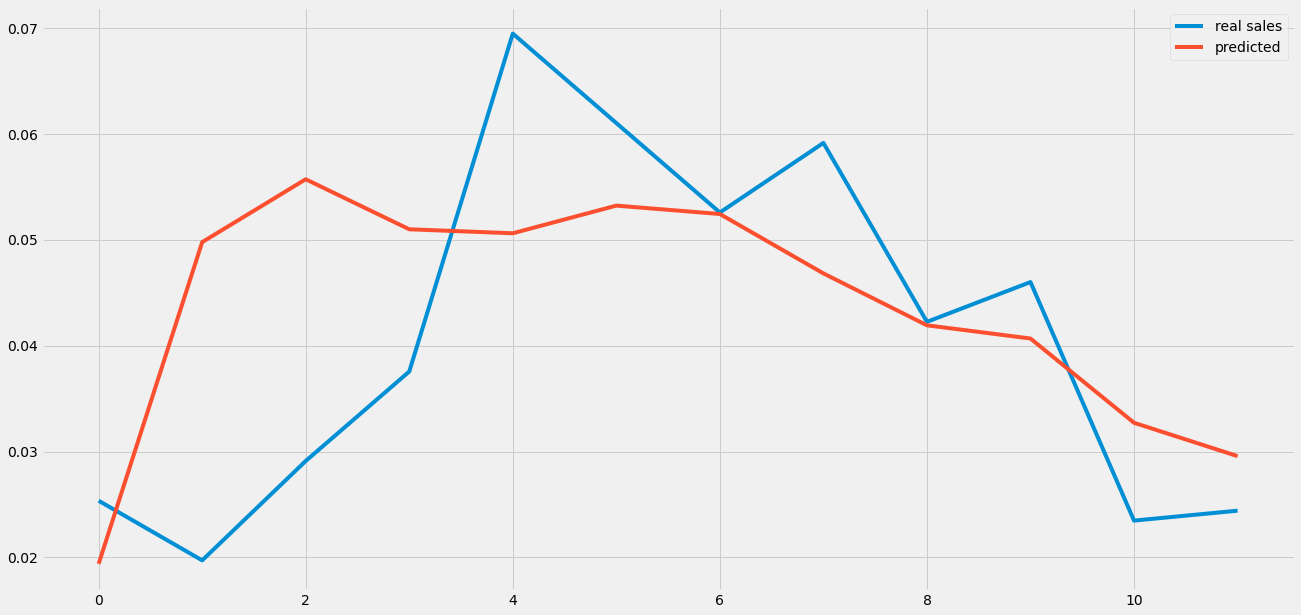

In [41]:
ii = 80
plt.plot(y0.values[ii,:], label = "real sales")
plt.plot(mo_prediction[ii,:], label = "predicted")
plt.legend()
plt.show()